## Importing libraries

In [1]:
import gymnasium as gym
import pde_control_gym
import numpy as np
import matplotlib.pyplot as plt

## Initializing Gym

In [2]:
T = 240
dt = 0.25
dx = 10
X = 500

from pde_control_gym.src import TrafficARZReward
reward_class =  TrafficARZReward()

Parameters = {
        "T": T, 
        "dt": dt, 
        "X": X,
        "dx": dx, 
        "reward_class": reward_class,
        "simulation_type" : 'inlet', 
        "v_steady" : 10,
        "ro_steady" : 0.12,
        "v_max" : 40,
        "ro_max" : 0.16,
        "tau" : 60,
        "control_freq" : 1
}

## PDE Backstepping kernels

In [3]:
def runSingleEpisode(model, env, parameter = None):
    terminate = False
    truncate = False

    # Holds the resulting states 
    uStorage = []

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    ns = 0
    i = 0

    #Cummulative reward
    rew = 0

    #Storing action and reward history
    act_h = []
    rew_h = []
    
    while not truncate and not terminate:
        action = model(env,obs,parameter)
        act_h.append(action)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards
        rew_h.append(rewards)
        ns += 1
    u = np.array(uStorage)
    return rew, u, act_h, rew_h

def bcksController(env, obs, parameter=None):
    if env.unwrapped.simulation_type == 'inlet':
        #Inlet control
        return env.unwrapped.qs
        
    elif env.unwrapped.simulation_type == 'outlet' or env.unwrapped.simulation_type == 'both':
        #Outlet control
        x = np.arange(0, env.unwrapped.L + env.unwrapped.dx, env.unwrapped.dx)
        lambda1 = env.unwrapped.vs
        lambda2 = env.unwrapped.vs + env.unwrapped.rs * (-env.unwrapped.vm / env.unwrapped.rm)

        gamma = 1
        K_kernel = -(1 / (gamma * env.unwrapped.ps)) * (-1 / env.unwrapped.tau) * np.exp(-x / (env.unwrapped.tau * env.unwrapped.vs))
        M_kernel = - K_kernel
    
        cv = M_kernel + (lambda2 / lambda1) * K_kernel * np.exp(x / (env.unwrapped.vs * env.unwrapped.tau))
        cq = ((lambda1 - lambda2) / lambda1) * K_kernel * np.exp(x / (env.unwrapped.vs * env.unwrapped.tau))
       
        v = env.unwrapped.v
        q = env.unwrapped.r * env.unwrapped.v
        v_err = v - env.unwrapped.vs
        q_err = q - env.unwrapped.qs
    
        integral_v = np.trapz(cv.flatten() * v_err.flatten(), dx=env.unwrapped.dx)
        integral_q = np.trapz(cq.flatten() * q_err.flatten(), dx=env.unwrapped.dx)

        q_out = env.unwrapped.qs + env.unwrapped.rs * integral_v + integral_q
        
        if env.unwrapped.simulation_type == 'outlet':
            return q_out
        else:
            return (env.unwrapped.qs,q_out)

## Backstepping Outlet Control

In [5]:
Parameters["simulation_type"] = 'outlet'
envBcks = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
rewBcksTen, uBcksTen, act_h, rew_h = runSingleEpisode(bcksController, envBcks,None )

Case 1: Outlet Boundary Control
0.12 10


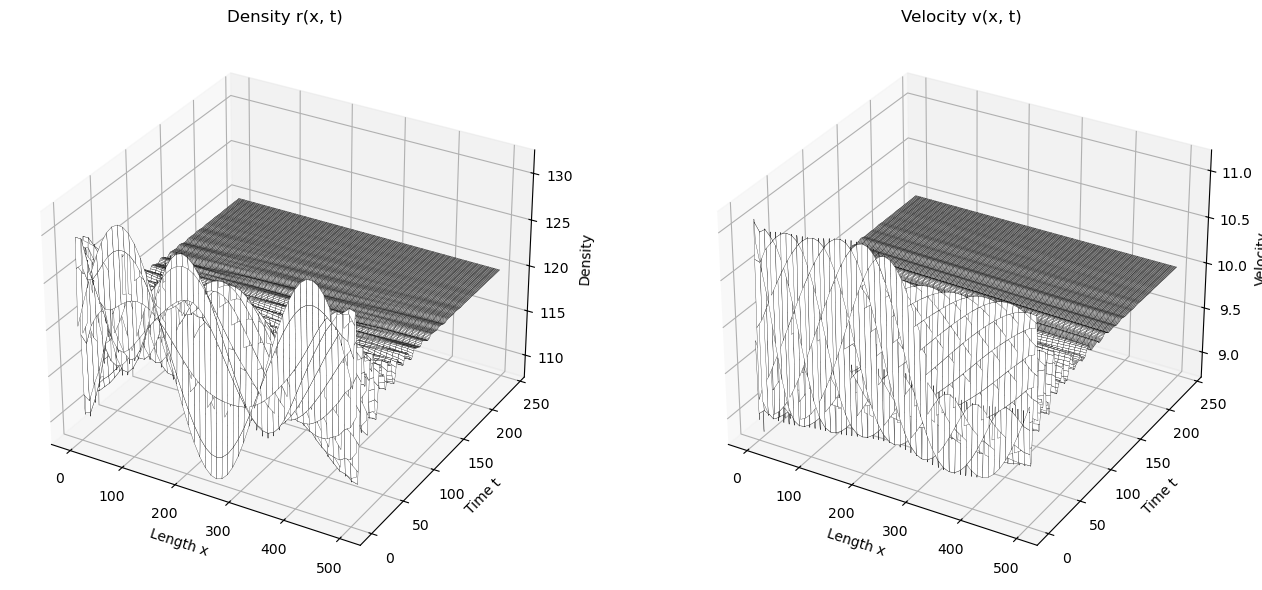

In [6]:
# Scale density
uBcksTen[:, :50] *= 1000

# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, uBcksTen.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, uBcksTen[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, uBcksTen[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

plt.tight_layout()
plt.show()

## Backstepping Inlet Control

In [7]:
Parameters["simulation_type"] = 'inlet'
envBcks = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
rewBcksTen, uBcksTen, act_h, rew_h = runSingleEpisode(bcksController, envBcks,None )

Case 2: Inlet Boundary Control
0.12 10


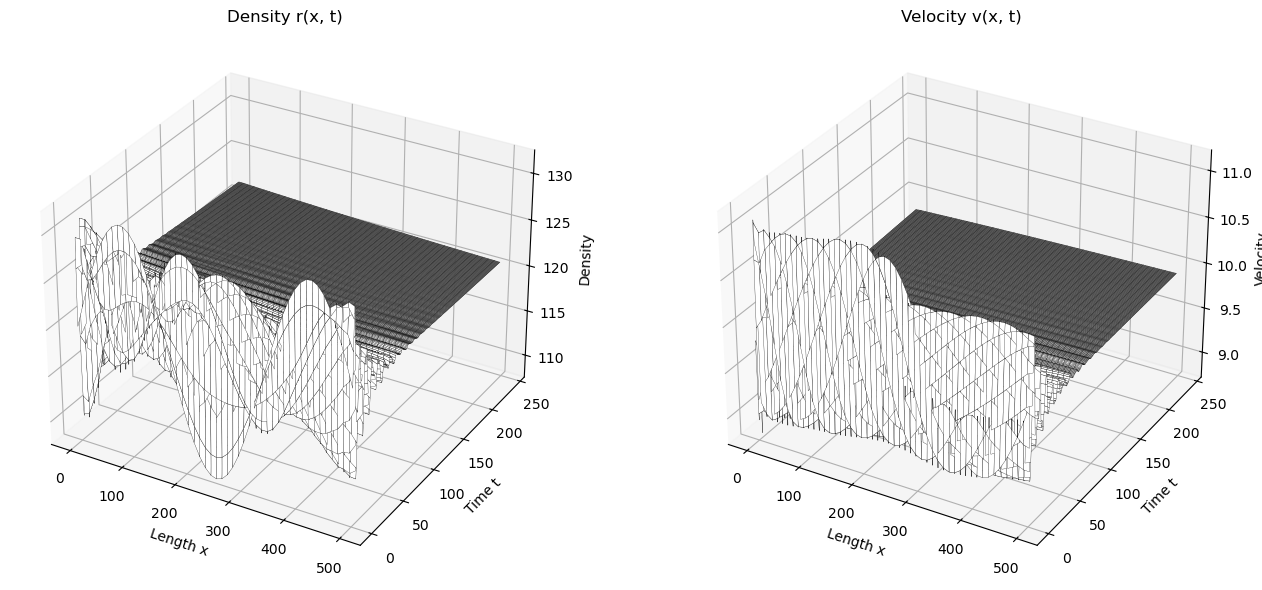

In [8]:
# Scale density
uBcksTen[:, :50] *= 1000

# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, uBcksTen.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, uBcksTen[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, uBcksTen[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

plt.tight_layout()
plt.show()

## Backstepping Outlet and Inlet Control

In [9]:
Parameters["simulation_type"] = 'both'
envBcks = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
rewBcksTen, uBcksTen, act_h, rew_h = runSingleEpisode(bcksController, envBcks, None)

Case 3: Outlet & Inlet Boundary Control
0.12 10


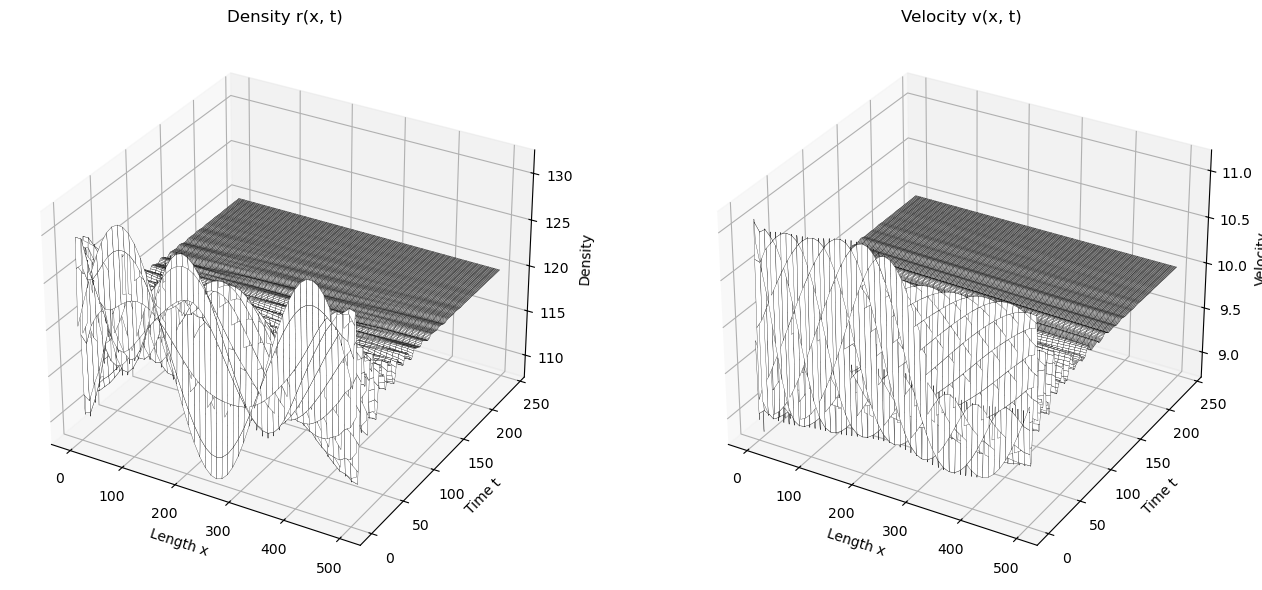

In [10]:
# Scale density
uBcksTen[:, :50] *= 1000

# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, uBcksTen.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, uBcksTen[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, uBcksTen[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

plt.tight_layout()
plt.show()